<a href="https://colab.research.google.com/github/harsha1-d/harsha1-d/blob/main/Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines
!pip install reliability

### Phase 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from lifelines import WeibullFitter, KaplanMeierFitter, CoxPHFitter  # CHANGED: Added CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import qth_survival_time
from scipy.special import gamma
from reliability.Fitters import Fit_Weibull_2P

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
df = pd.read_csv('DirtSlurper3100.csv', skiprows=12)
# , skiprows=12
print(df.head(10))

df['Registration date'] = pd.to_datetime(df['Registration date'], format='%d%b%Y')
df['Failure date'] = df['Failure date'].replace('---', pd.NaT)
df['Failure date'] = pd.to_datetime(df['Failure date'], format='%d%b%Y', errors='coerce')

df['days'] = (df['Failure date'] - df['Registration date']).dt.days
df['days'] = df['days'].fillna(
    (pd.to_datetime('2019-12-31') - df['Registration date']).dt.days
)

# Events
df['Battery_event'] = ((df['Battery status'] == 'Damage') &
                       (df['Sent for repair'] == 'YES')).astype(int)
df['Impact_event'] = ((df['Impact status'] == 'Damage') &
                      (df['Sent for repair'] == 'YES')).astype(int)
df['IR_event'] = ((df['IR status'] == 'Damage') &
                  (df['Sent for repair'] == 'YES')).astype(int)

# Covariates
df['Pets'] = (df['Pets'] == 'YES').astype(int)
df['Carpet_score'] = df['Carpet score']
df['usage'] = df['Total usage time']

df['days_positive'] = df['days'].clip(lower=0.5)
df_ir = df[df['days_positive'] > 0].copy()

print(f"Dataset loaded: {len(df)} devices")
print(f"Study period: January 2015 - December 2019\n")

  Registration date  Total usage time Pets  Carpet score Sent for repair Failure date Battery status Impact status IR status
0         29Jul2019               233   NO             5              NO          ---            ---           ---       ---
1          8Sep2019               152   NO             3              NO          ---            ---           ---       ---
2          6Jun2016               475   NO             2             YES     7Nov2017             OK            OK    Damage
3         25Feb2019               326   NO             4              NO          ---            ---           ---       ---
4         17Mar2018              1018  YES             4              NO          ---            ---           ---       ---
5          5Aug2017              1312   NO             2              NO          ---            ---           ---       ---
6          7Sep2018              1172  YES             4              NO          ---            ---           ---       ---


All devices (n=6473): r = 0.720
Failed devices (n=1050): r = 0.745


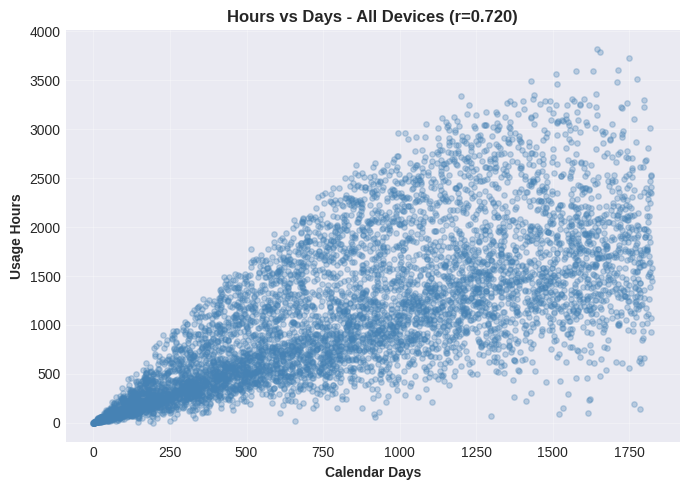

Battery: 679 failures (10.5%), 5794 censored
Impact: 91 failures (1.4%), 6382 censored
IR: 282 failures (4.4%), 6191 censored
Pets: 2629 devices (40.6%)
Carpet score: mean=3.22, std=1.33
Days: mean=823.4, median=795.0, range=[0, 1825]


In [ ]:
corr_all = df[['usage', 'days']].corr().iloc[0,1]
df_failed = df[(df['Battery_event'] + df['Impact_event'] + df['IR_event']) > 0]
corr_failed = df_failed[['Total usage time', 'days']].corr().iloc[0,1]

print(f"All devices (n={len(df)}): r = {corr_all:.3f}")
print(f"Failed devices (n={len(df_failed)}): r = {corr_failed:.3f}")

plt.figure(figsize=(7, 5))
plt.scatter(df['days'], df['usage'], alpha=0.3, s=15, color='steelblue')
plt.xlabel('Calendar Days', fontweight='bold')
plt.ylabel('Usage Hours', fontweight='bold')
plt.title(f'Hours vs Days - All Devices (r={corr_all:.3f})', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

for name, col in [('Battery', 'Battery_event'), ('Impact', 'Impact_event'), ('IR', 'IR_event')]:
    n_fail = df[col].sum()
    print(f"{name}: {n_fail} failures ({n_fail/len(df)*100:.1f}%), {len(df)-n_fail} censored")

print(f"Pets: {df['Pets'].sum()} devices ({df['Pets'].mean()*100:.1f}%)")
print(f"Carpet score: mean={df['Carpet_score'].mean():.2f}, std={df['Carpet_score'].std():.2f}")
print(f"Days: mean={df['days'].mean():.1f}, median={df['days'].median():.1f}, range=[{df['days'].min():.0f}, {df['days'].max():.0f}]")

In [ ]:
summary_data = []
for name, event_col in [('Battery', 'Battery_event'), ('Impact', 'Impact_event'), ('IR', 'IR_event')]:
    failures = df[df[event_col]==1]['days']

    if len(failures) > 0:
        summary_data.append({
            'Component': name,
            'Failures': len(failures),
            'Failure_Rate_%': len(failures)/len(df)*100,
            'Mean_TTF': failures.mean(),
            'Median_TTF': failures.median(),
            'Min_TTF': failures.min(),
            'Max_TTF': failures.max()
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

Component  Failures  Failure_Rate_%  Mean_TTF  Median_TTF  Min_TTF  Max_TTF
  Battery       679         10.4897   870.345         850      114     1800
   Impact        91         1.40584   1306.16        1320      680     1765
       IR       282         4.35656   582.869       492.5        7     1703


### Phase 2

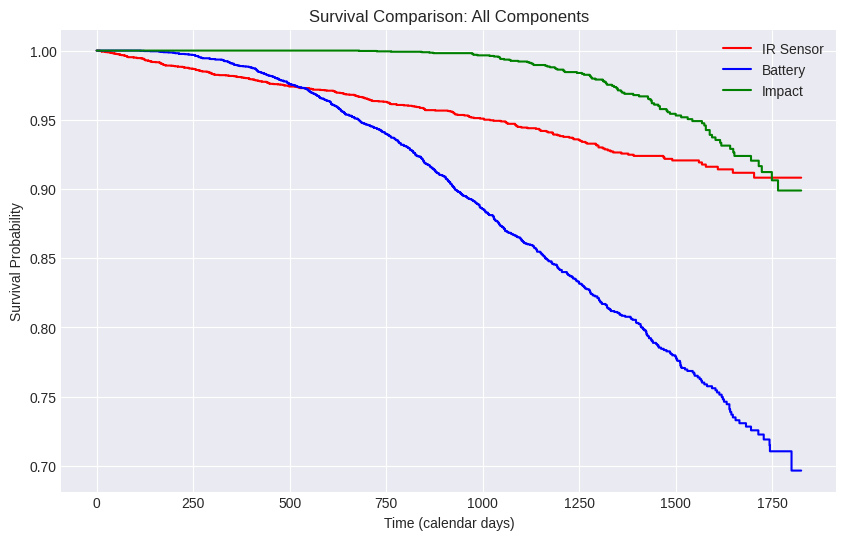

IR: 282 failures (4.4%)
Battery: 679 failures (10.5%)
Impact: 91 failures (1.4%)


In [ ]:
plt.figure(figsize=(10,6))
kmf = KaplanMeierFitter()

for event_col, label, color in [('IR_event', 'IR Sensor', 'red'),
                                  ('Battery_event', 'Battery', 'blue'),
                                  ('Impact_event', 'Impact', 'green')]:
    kmf.fit(df_ir['days_positive'], df_ir[event_col], label=label)
    kmf.plot_survival_function(ci_show=False, color=color)

plt.title('Survival Comparison: All Components')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

for name, event_col in [('IR', 'IR_event'), ('Battery', 'Battery_event'), ('Impact', 'Impact_event')]:
    n_fail = df_ir[event_col].sum()
    print(f"{name}: {n_fail} failures ({n_fail/len(df_ir)*100:.1f}%)")

### IR

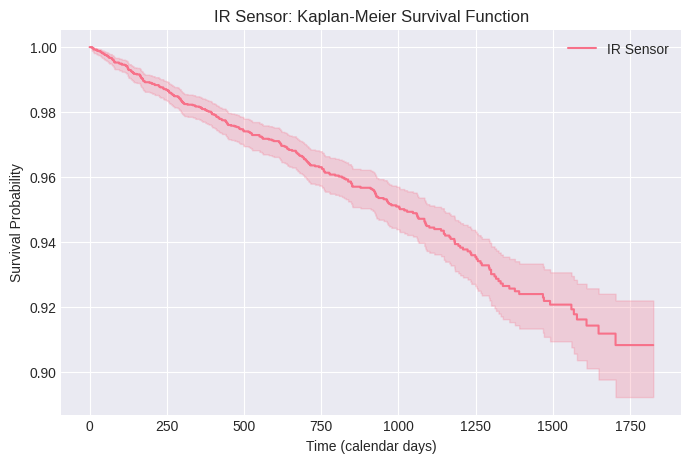


Log-rank test for Pets:
  Chi-square: 0.0670
  p-value: 0.7957

Log-rank test for Carpet Score:
  Chi-square: 0.0340
  p-value: 0.8536



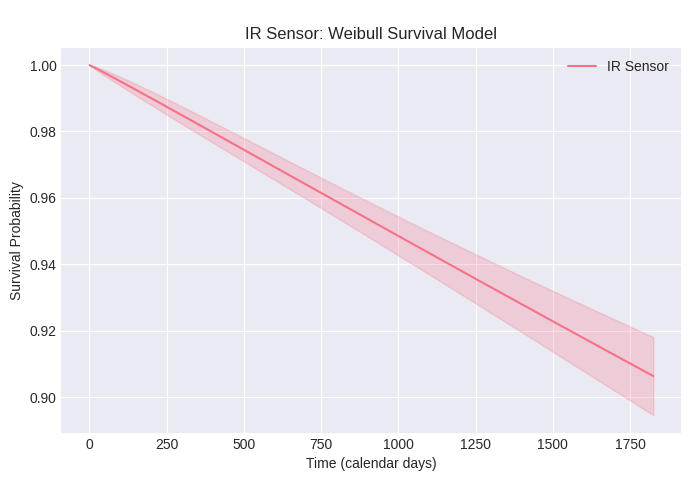

  Weibull Parameters:
  Shape (ρ): 1.032
  Scale (λ): 17245.849
  AIC: 6121.273

Reliability Metrics:
  L10 (90% survive): 1949.8 days
  Median lifetime: 12092.0 days
  MTTF (mean): 17024.3 days
  Log-likelihood: -3058.64

Claim Test:
  Claim: L10 ≥ 2000 days
  Estimate: L10 = 1950 days


In [ ]:

# Kaplan-Meier
kmf_ir = KaplanMeierFitter()
kmf_ir.fit(durations=df_ir['days_positive'],
           event_observed=df_ir['IR_event'],
           label='IR Sensor')

plt.figure(figsize=(8,5))
kmf_ir.plot_survival_function(ci_show=True)
plt.title('IR Sensor: Kaplan-Meier Survival Function')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


#log-rank test
group1 = df[df["Pets"] == 1]
group2 = df[df["Pets"] == 0]

resultpet = logrank_test(
    durations_A = group1["days_positive"],
    durations_B = group2["days_positive"],
    event_observed_A = group1["IR_event"],
    event_observed_B = group2["IR_event"]
)
low_carpet = df[df['Carpet_score'] < 5]
high_carpet = df[df['Carpet_score'] >= 5]

resultcarpet = logrank_test(
    high_carpet['days_positive'], low_carpet['days_positive'],
    event_observed_A=high_carpet['IR_event'],
    event_observed_B=low_carpet['IR_event']
)
print("\nLog-rank test for Pets:")
print(f"  Chi-square: {resultpet.test_statistic:.4f}")
print(f"  p-value: {resultpet.p_value:.4f}")
print("\nLog-rank test for Carpet Score:")
print(f"  Chi-square: {resultcarpet.test_statistic:.4f}")
print(f"  p-value: {resultcarpet.p_value:.4f}\n")

# Weibull parametric model
wf_ir = WeibullFitter()
wf_ir.fit(durations=df_ir['days_positive'],
          event_observed=df_ir['IR_event'],
          label='IR Sensor')

plt.figure(figsize=(8,5))
wf_ir.plot_survival_function()
plt.title('\nIR Sensor: Weibull Survival Model')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# Extract parameters
shape_ir = wf_ir.rho_
scale_ir = wf_ir.lambda_
median_ir = wf_ir.median_survival_time_
aic_ir = wf_ir.AIC_
log_likelihood_ir = wf_ir.log_likelihood_


l10_ir = wf_ir.percentile(0.90)


# MTTF for Weibull
mttf_ir = scale_ir * gamma(1 + 1/shape_ir)


print(f"  Weibull Parameters:")
print(f"  Shape (ρ): {shape_ir:.3f}")
print(f"  Scale (λ): {scale_ir:.3f}")
print(f"  AIC: {aic_ir:.3f}")
print(f"\nReliability Metrics:")
print(f"  L10 (90% survive): {l10_ir:.1f} days")
print(f"  Median lifetime: {median_ir:.1f} days")
print(f"  MTTF (mean): {mttf_ir:.1f} days")
print(f"  Log-likelihood: {log_likelihood_ir:.2f}")

print(f"\nClaim Test:")
print(f"  Claim: L10 ≥ 2000 days")
print(f"  Estimate: L10 = {l10_ir:.0f} days")


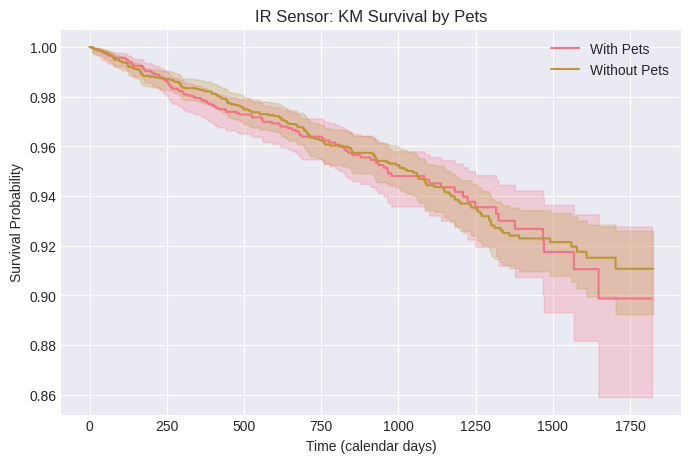

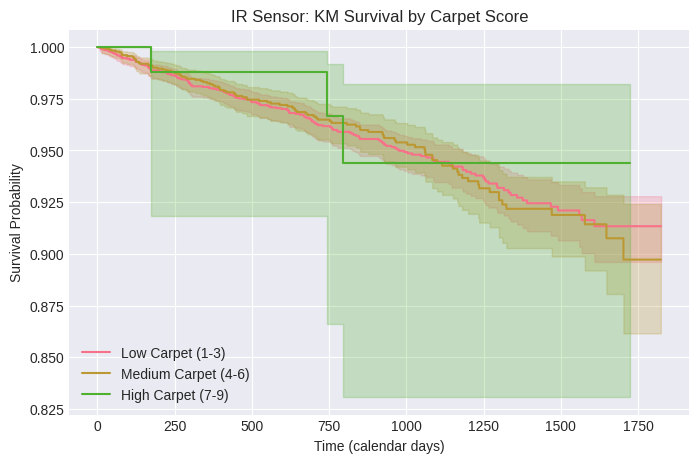

Carpet_group
Low       4028
Medium    2348
High        97
Name: count, dtype: int64


In [ ]:
# Stratified by Pets
plt.figure(figsize=(8,5))
kmf = KaplanMeierFitter()

for pets_status, label in [(1, 'With Pets'), (0, 'Without Pets')]:
    mask = df_ir['Pets'] == pets_status
    kmf.fit(durations=df_ir[mask]['days_positive'],
            event_observed=df_ir[mask]['IR_event'],
            label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title('IR Sensor: KM Survival by Pets')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()


# Stratified by Carpet Score
plt.figure(figsize=(8,5))

for carpet_group, label in [('low', 'Low Carpet (1-3)'), ('medium', 'Medium Carpet (4-6)'), ('high', 'High Carpet (7-9)')]:
    if carpet_group == 'low':
        mask = (df_ir['Carpet_score'] >= 1) & (df_ir['Carpet_score'] <= 3)
    elif carpet_group == 'medium':
        mask = (df_ir['Carpet_score'] >= 4) & (df_ir['Carpet_score'] <= 6)
    else:
        mask = (df_ir['Carpet_score'] >= 7) & (df_ir['Carpet_score'] <= 9)

    kmf.fit(durations=df_ir[mask]['days_positive'],
            event_observed=df_ir[mask]['IR_event'],
            label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title('IR Sensor: KM Survival by Carpet Score')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

df_ir['Carpet_group'] = pd.cut(df_ir['Carpet_score'],
                               bins=[0, 3, 6, 9],
                               labels=['Low', 'Medium', 'High'])

print(df_ir['Carpet_group'].value_counts())


In [ ]:
# Cox Proportional Hazards model
cph_ir = CoxPHFitter()
cph_ir.fit(df_ir[['days_positive', 'IR_event', 'Pets', 'Carpet_score']],
           duration_col='days_positive',
           event_col='IR_event')

print("\n=== Cox PH Model (IR Sensor) ===")
print(cph_ir.summary[['coef', 'exp(coef)', 'se(coef)', 'p']])
print(f"\nConcordance: {cph_ir.concordance_index_:.3f}")
print(f"Log-likelihood: {cph_ir.log_likelihood_:.2f}")
print(f"AIC (partial): {cph_ir.AIC_partial_:.2f}")


=== Cox PH Model (IR Sensor) ===
                    coef  exp(coef)  se(coef)        p
covariate                                             
Pets           0.0319436    1.03246  0.123637 0.796125
Carpet_score -0.00119339   0.998807 0.0451146 0.978897

Concordance: 0.506
Log-likelihood: -2313.67
AIC (partial): 4631.34


In [ ]:
# calculating CI 95% for IR L10 value
failures = df_ir[df_ir['IR_event'] == 1]['days_positive'].values
censored = df_ir[df_ir['IR_event'] == 0]['days_positive'].values
results = Fit_Weibull_2P(
    failures=failures,
    right_censored=censored,
    CI=0.95,
    quantiles=[0.10],
    CI_type='time',
    show_probability_plot=False
)

quantiles_df = results.quantiles
l10_row = quantiles_df[quantiles_df['Quantile'] == 0.1]


l10_point = l10_row['Point Estimate'].iloc[0]
l10_lower_ci = l10_row['Lower Estimate'].iloc[0]
l10_upper_ci = l10_row['Upper Estimate'].iloc[0]

print(f"\n--- L10 (10% Failure) Results using reliability ---")
print(f"L10 Point Estimate: {l10_point:.2f} days")
print(f"95% CI Lower Bound: {l10_lower_ci:.2f} days")
print(f"95% CI Upper Bound: {l10_upper_ci:.2f} days")
print(f"95% Confidence Interval for L10: ({l10_lower_ci:.2f}, {l10_upper_ci:.2f}) days")




Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 282/6191 (95.64344% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         17245.8          2745.3   12623.6   23560.5
     Beta         1.03235       0.0542068  0.931389   1.14425 

Goodness of fit    Value
 Log-likelihood -3058.64
           AICc  6121.28
            BIC  6134.82
             AD  6154.21 

Table of quantiles (95% CI bounds on time):
 Quantile  Lower Estimate  Point Estimate  Upper Estimate
      0.1         1710.14         1949.78         2223.01 


--- L10 (10% Failure) Results using reliability ---
L10 Point Estimate: 1949.78 days
95% CI Lower Bound: 1710.14 days
95% CI Upper Bound: 2223.01 days
95% Confidence Interval for L10: (1710.14, 2223.01) days


### Battery

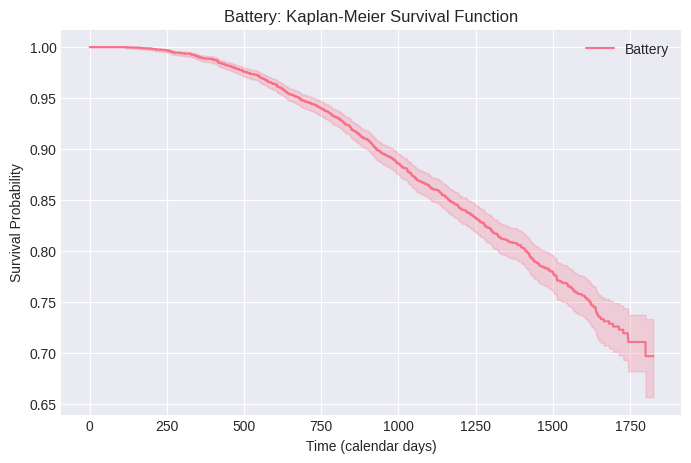

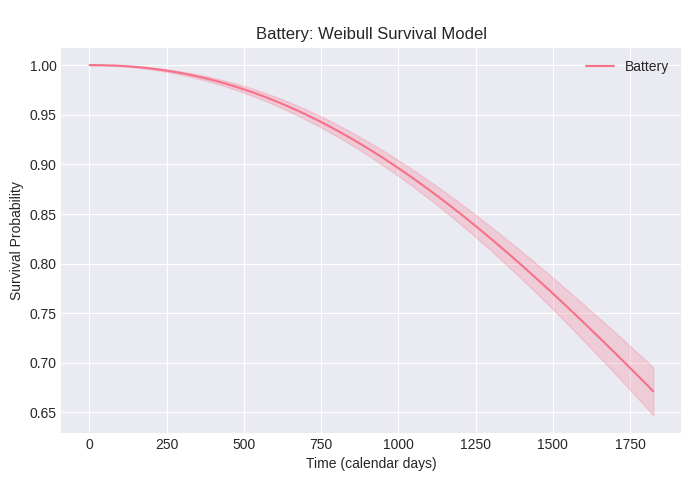

  Weibull Parameters:
  Shape (ρ): 2.145
  Scale (λ): 2802.249
  AIC: 13090.619

Reliability Metrics:
  L10 (90% survive): 981.7 days
  Median lifetime: 2362.2 days
  MTTF (mean): 2481.7 days
  Log-likelihood: -6543.31

Manufacturer Claim Test:
  Claim: L10 ≥ 1000 days
  Estimate: L10 = 982 days


In [ ]:
kmf_battery = KaplanMeierFitter()
kmf_battery.fit(durations=df_ir['days_positive'],
                event_observed=df_ir['Battery_event'],
                label='Battery')

plt.figure(figsize=(8,5))
kmf_battery.plot_survival_function(ci_show=True)
plt.title('Battery: Kaplan-Meier Survival Function')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

print()
print()

# Weibull parametric model
wf_ir = WeibullFitter()
wf_ir.fit(durations=df_ir['days_positive'],
          event_observed=df_ir['Battery_event'],
          label='Battery')

plt.figure(figsize=(8,5))
wf_ir.plot_survival_function()
plt.title('\nBattery: Weibull Survival Model')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# Extract parameters
shape_ir = wf_ir.rho_
scale_ir = wf_ir.lambda_
median_ir = wf_ir.median_survival_time_
aic_ir = wf_ir.AIC_
log_likelihood_ir = wf_ir.log_likelihood_


l10_ir = wf_ir.percentile(0.90)


# MTTF for Weibull
mttf_ir = scale_ir * gamma(1 + 1/shape_ir)


print(f"  Weibull Parameters:")
print(f"  Shape (ρ): {shape_ir:.3f}")
print(f"  Scale (λ): {scale_ir:.3f}")
print(f"  AIC: {aic_ir:.3f}")
print(f"\nReliability Metrics:")
print(f"  L10 (90% survive): {l10_ir:.1f} days")
print(f"  Median lifetime: {median_ir:.1f} days")
print(f"  MTTF (mean): {mttf_ir:.1f} days")
print(f"  Log-likelihood: {log_likelihood_ir:.2f}")

print(f"\nManufacturer Claim Test:")
print(f"  Claim: L10 ≥ 1000 days")
print(f"  Estimate: L10 = {l10_ir:.0f} days")



With Pets: n=2629, failures=593 (22.6%)
Without Pets: n=3844, failures=86 (2.2%)


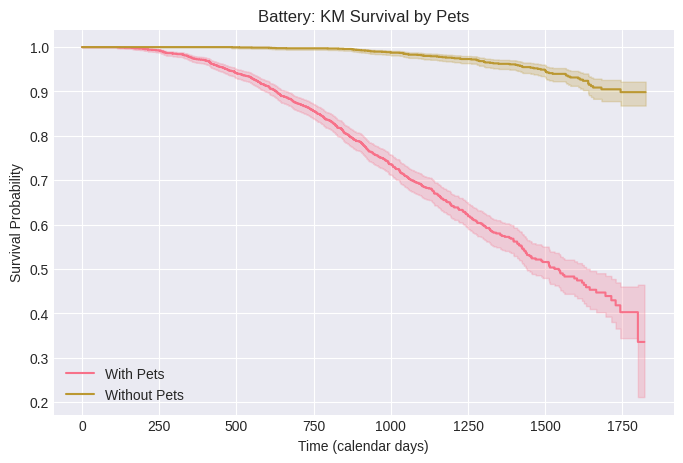

Low Carpet (1-3): n=4028, failures=393 (9.8%)
Medium Carpet (4-6): n=2348, failures=269 (11.5%)
High Carpet (7-9): n=97, failures=17 (17.5%)


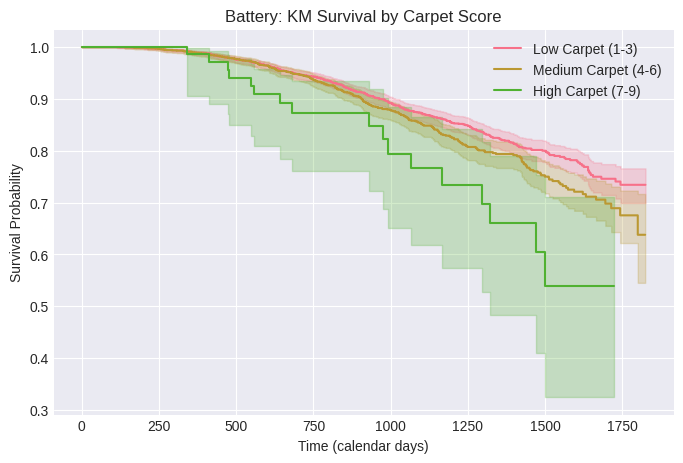

In [ ]:
# Stratified by Pets
for pets_status, label in [(1, 'With Pets'), (0, 'Without Pets')]:
    mask = df_ir['Pets'] == pets_status
    n_total = mask.sum()
    n_fail = df_ir[mask]['Battery_event'].sum()
    print(f"{label}: n={n_total}, failures={n_fail} ({n_fail/n_total*100:.1f}%)")

plt.figure(figsize=(8,5))
kmf = KaplanMeierFitter()

for pets_status, label in [(1, 'With Pets'), (0, 'Without Pets')]:
    mask = df_ir['Pets'] == pets_status
    kmf.fit(durations=df_ir[mask]['days_positive'],
            event_observed=df_ir[mask]['Battery_event'],
            label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title('Battery: KM Survival by Pets')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

# Stratified by Carpet Score
carpet_groups = [
    ((df_ir['Carpet_score'] >= 1) & (df_ir['Carpet_score'] <= 3), 'Low Carpet (1-3)'),
    ((df_ir['Carpet_score'] >= 4) & (df_ir['Carpet_score'] <= 6), 'Medium Carpet (4-6)'),
    ((df_ir['Carpet_score'] >= 7) & (df_ir['Carpet_score'] <= 9), 'High Carpet (7-9)')
]

for mask, label in carpet_groups:
    n_total = mask.sum()
    n_fail = df_ir[mask]['Battery_event'].sum()
    print(f"{label}: n={n_total}, failures={n_fail} ({n_fail/n_total*100:.1f}%)")

plt.figure(figsize=(8,5))

for mask, label in carpet_groups:
    kmf.fit(durations=df_ir[mask]['days_positive'],
            event_observed=df_ir[mask]['Battery_event'],
            label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title('Battery: KM Survival by Carpet Score')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
# Log-rank tests
from lifelines.statistics import logrank_test

group1_battery = df[df["Pets"] == 1]
group2_battery = df[df["Pets"] == 0]

resultpet_battery = logrank_test(
    durations_A = group1_battery["days_positive"],
    durations_B = group2_battery["days_positive"],
    event_observed_A = group1_battery["Battery_event"],
    event_observed_B = group2_battery["Battery_event"]
)

low_carpet_battery = df[df['Carpet_score'] < 5]
high_carpet_battery = df[df['Carpet_score'] >= 5]

resultcarpet_battery = logrank_test(
    high_carpet_battery['days_positive'], low_carpet_battery['days_positive'],
    event_observed_A=high_carpet_battery['Battery_event'],
    event_observed_B=low_carpet_battery['Battery_event']
)

print("\nLog-rank test for Pets (Battery):")
print(f"  Chi-square: {resultpet_battery.test_statistic:.4f}")
print(f"  p-value: {resultpet_battery.p_value:.4f}")
print("\nLog-rank test for Carpet Score (Battery):")
print(f"  Chi-square: {resultcarpet_battery.test_statistic:.4f}")
print(f"  p-value: {resultcarpet_battery.p_value:.4f}")




Log-rank test for Pets (Battery):
  Chi-square: 875.8850
  p-value: 0.0000

Log-rank test for Carpet Score (Battery):
  Chi-square: 12.4696
  p-value: 0.0004


In [ ]:
# Weibull on Unfiltered data

# Without pets (best case)
no_pets_unfiltered = df_ir[df_ir['Pets'] == 0]
wf_no_pets_unfiltered = WeibullFitter()
wf_no_pets_unfiltered.fit(no_pets_unfiltered['days_positive'], no_pets_unfiltered['Battery_event'])
l10_no_pets_unfiltered = wf_no_pets_unfiltered.percentile(0.90)

# With pets (worst case)
pets_unfiltered = df_ir[df_ir['Pets'] == 1]
wf_pets_unfiltered = WeibullFitter()
wf_pets_unfiltered.fit(pets_unfiltered['days_positive'], pets_unfiltered['Battery_event'])
l10_pets_unfiltered = wf_pets_unfiltered.percentile(0.90)

# Low carpet score
low_carpet_unfiltered = df_ir[(df_ir["Carpet_score"] >= 1) & (df_ir["Carpet_score"] <= 3)]
wf_low_carpet_unfiltered = WeibullFitter()
wf_low_carpet_unfiltered.fit(low_carpet_unfiltered['days_positive'], low_carpet_unfiltered['Battery_event'])
l10_low_carpet_unfiltered = wf_low_carpet_unfiltered.percentile(0.90)

# Medium carpet score
medium_carpet_unfiltered = df_ir[(df_ir["Carpet_score"] >= 4) & (df_ir["Carpet_score"] <= 6)]
wf_medium_carpet_unfiltered = WeibullFitter()
wf_medium_carpet_unfiltered.fit(medium_carpet_unfiltered['days_positive'], medium_carpet_unfiltered['Battery_event'])
l10_medium_carpet_unfiltered = wf_medium_carpet_unfiltered.percentile(0.90)

# High carpet score
high_carpet_unfiltered = df_ir[(df_ir["Carpet_score"] >= 7) & (df_ir["Carpet_score"] <= 9)]
wf_high_carpet_unfiltered = WeibullFitter()
wf_high_carpet_unfiltered.fit(high_carpet_unfiltered['days_positive'], high_carpet_unfiltered['Battery_event'])
l10_high_carpet_unfiltered = wf_high_carpet_unfiltered.percentile(0.90)


print(f"Without Pets: L10 = {l10_no_pets_unfiltered:.0f} days (Claim: {'YES' if l10_no_pets_unfiltered >= 1000 else 'NO'})")
print(f"With Pets: L10 = {l10_pets_unfiltered:.0f} days (Claim: {'YES' if l10_pets_unfiltered >= 1000 else 'NO'})")
print(f"Low carpet score: L10 = {l10_low_carpet_unfiltered:.0f} days (Claim: {'YES' if l10_low_carpet_unfiltered >= 1000 else 'NO'})")
print(f"Medium carpet score: L10 = {l10_medium_carpet_unfiltered:.0f} days (Claim: {'YES' if l10_medium_carpet_unfiltered >= 1000 else 'NO'})")
print(f"High carpet score: L10 = {l10_high_carpet_unfiltered:.0f} days (Claim: {'YES' if l10_high_carpet_unfiltered >= 1000 else 'NO'})")

Without Pets: L10 = 1749 days (Claim: YES)
With Pets: L10 = 643 days (Claim: NO)
Low carpet score: L10 = 1015 days (Claim: YES)
Medium carpet score: L10 = 947 days (Claim: NO)
High carpet score: L10 = 743 days (Claim: NO)


In [ ]:
# calculating CI 95% for Battry L10 value (Unfiltered)
failures_unfiltered = df_ir[df_ir['Battery_event'] == 1]['days_positive'].values
censored_unfiltered = df_ir[df_ir['Battery_event'] == 0]['days_positive'].values
results_unfiltered = Fit_Weibull_2P(
    failures=failures_unfiltered,
    right_censored=censored_unfiltered,
    CI=0.95,
    quantiles=[0.10],
    CI_type='time',
    show_probability_plot=False
)

quantiles_df_unfiltered = results_unfiltered.quantiles
l10_row_unfiltered = quantiles_df_unfiltered[quantiles_df_unfiltered['Quantile'] == 0.1]


l10_point_unfiltered = l10_row_unfiltered['Point Estimate'].iloc[0]
l10_lower_ci_unfiltered = l10_row_unfiltered['Lower Estimate'].iloc[0]
l10_upper_ci_unfiltered = l10_row_unfiltered['Upper Estimate'].iloc[0]

print(f"\n--- L10 (10% Failure) Results using reliability ---")
print(f"L10 Point Estimate: {l10_point_unfiltered:.2f} days")
print(f"95% CI Lower Bound: {l10_lower_ci_unfiltered:.2f} days")
print(f"95% CI Upper Bound: {l10_upper_ci_unfiltered:.2f} days")
print(f"95% Confidence Interval for L10: ({l10_lower_ci_unfiltered:.2f}, {l10_upper_ci_unfiltered:.2f}) days")

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 679/5794 (89.51027% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         2802.25         86.1417    2638.4   2976.27
     Beta         2.14546       0.0662084   2.01954   2.27923 

Goodness of fit    Value
 Log-likelihood -6543.31
           AICc  13090.6
            BIC  13104.2
             AD  8583.86 

Table of quantiles (95% CI bounds on time):
 Quantile  Lower Estimate  Point Estimate  Upper Estimate
      0.1          945.17         981.696         1019.63 


--- L10 (10% Failure) Results using reliability ---
L10 Point Estimate: 981.70 days
95% CI Lower Bound: 945.17 days
95% CI Upper Bound: 1019.63 days
95% Confidence Interval for L10: (945.17, 1019.63) days


In [ ]:
df_filtered = df_ir[df_ir['usage'] < 2400]
print(f"Devices after filtering: {len(df_filtered)}")

wf_battery_filtered = WeibullFitter()
wf_battery_filtered.fit(durations=df_filtered['days_positive'],
                        event_observed=df_filtered['Battery_event'],
                        label='Battery (Filtered)')

shape_filtered = wf_battery_filtered.rho_
scale_filtered = wf_battery_filtered.lambda_
median_filtered = wf_battery_filtered.median_survival_time_
l10_filtered = wf_battery_filtered.percentile(0.90)
mttf_filtered = scale_filtered * gamma(1 + 1/shape_filtered)

print(f"\nWeibull Parameters:")
print(f"  Shape (ρ): {shape_filtered:.3f}")
print(f"  Scale (λ): {scale_filtered:.3f}")
print(f"\nReliability Metrics:")
print(f"  L10 (90% survive): {l10_filtered:.1f} days")
print(f"  Median lifetime: {median_filtered:.1f} days")
print(f"  MTTF (mean): {mttf_filtered:.1f} days")
print(f"\nManufacturer Claim Test:")
print(f"  Claim: L10 ≥ 1000 days")
print(f"  Estimate: L10 = {l10_filtered:.0f} days")

Devices after filtering: 6028

Weibull Parameters:
  Shape (ρ): 1.861
  Scale (λ): 3413.694

Reliability Metrics:
  L10 (90% survive): 1018.7 days
  Median lifetime: 2803.4 days
  MTTF (mean): 3031.4 days

Manufacturer Claim Test:
  Claim: L10 ≥ 1000 days
  Estimate: L10 = 1019 days


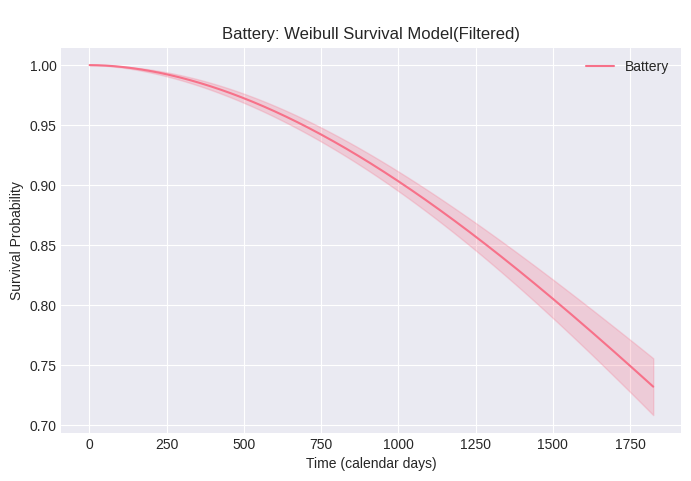

  Weibull Parameters:
  Shape (ρ): 1.861
  Scale (λ): 3413.694
  AIC: 10197.881

Reliability Metrics:
  L10 (90% survive): 1018.7 days
  Median lifetime: 2803.4 days
  MTTF (mean): 3031.4 days
  Log-likelihood: -5096.94

Manufacturer Claim Test:
  Claim: L10 ≥ 1000 days
  Estimate: L10 = 1019 days


In [ ]:
#Weibull graph with filtered data
wf_battery_filtered = WeibullFitter()
wf_battery_filtered.fit(durations=df_filtered['days_positive'],
          event_observed=df_filtered['Battery_event'],
          label='Battery')

plt.figure(figsize=(8,5))
wf_battery_filtered.plot_survival_function()
plt.title('\nBattery: Weibull Survival Model(Filtered)')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# Extract parameters
shape_battery_filtered = wf_battery_filtered.rho_
scale_battery_filtered = wf_battery_filtered.lambda_
median_battery_filtered = wf_battery_filtered.median_survival_time_
aic_battery_filtered = wf_battery_filtered.AIC_
log_likelihood_battery_filtered = wf_battery_filtered.log_likelihood_


l10_battery_filtered = wf_battery_filtered.percentile(0.90)


# MTTF for Weibull
mttf_battery_filtered = scale_battery_filtered * gamma(1 + 1/shape_battery_filtered)


print(f"  Weibull Parameters:")
print(f"  Shape (ρ): {shape_battery_filtered:.3f}")
print(f"  Scale (λ): {scale_battery_filtered:.3f}")
print(f"  AIC: {aic_battery_filtered:.3f}")
print(f"\nReliability Metrics:")
print(f"  L10 (90% survive): {l10_battery_filtered:.1f} days")
print(f"  Median lifetime: {median_battery_filtered:.1f} days")
print(f"  MTTF (mean): {mttf_battery_filtered:.1f} days")
print(f"  Log-likelihood: {log_likelihood_battery_filtered:.2f}")

print(f"\nManufacturer Claim Test:")
print(f"  Claim: L10 ≥ 1000 days")
print(f"  Estimate: L10 = {l10_battery_filtered:.0f} days")

In [ ]:

# Cox Proportional Hazards model
cph_battery = CoxPHFitter()
cph_battery.fit(df_ir[['days_positive', 'Battery_event', 'Pets', 'Carpet_score']],
                duration_col='days_positive',
                event_col='Battery_event')

print("\n=== Cox PH Model (Battery) ===")
print(cph_battery.summary[['coef', 'exp(coef)', 'se(coef)', 'p']])
print(f"\nConcordance: {cph_battery.concordance_index_:.3f}")
print(f"Log-likelihood: {cph_battery.log_likelihood_:.2f}")
print(f"AIC (partial): {cph_battery.AIC_partial_:.2f}")


=== Cox PH Model (Battery) ===
                coef  exp(coef)  se(coef)            p
covariate                                             
Pets         2.64318    14.0578  0.115959 5.24483e-115
Carpet_score 0.14108    1.15152 0.0277799  3.80479e-07

Concordance: 0.800
Log-likelihood: -4894.16
AIC (partial): 9792.31


In [ ]:
df_filtered = df_ir[df_ir['usage'] < 2400]
print(f"Devices after filtering: {len(df_filtered)}")

# Without pets (best case)
no_pets = df_filtered[df_filtered['Pets'] == 0]
wf_no_pets = WeibullFitter()
wf_no_pets.fit(no_pets['days_positive'], no_pets['Battery_event'])
l10_no_pets = wf_no_pets.percentile(0.90)

# With pets (worst case)
pets = df_filtered[df_filtered['Pets'] == 1]
wf_pets = WeibullFitter()
wf_pets.fit(pets['days_positive'], pets['Battery_event'])
l10_pets = wf_pets.percentile(0.90)

# Low carpet score
low_carpet = df_filtered[(df_filtered["Carpet_score"] >= 1) & (df_filtered["Carpet_score"] <= 3)]
wf_low_carpet = WeibullFitter()
wf_low_carpet.fit(low_carpet['days_positive'], low_carpet['Battery_event'])
l10_low_carpet = wf_low_carpet.percentile(0.90)

# Medium carpet score
medium_carpet = df_filtered[(df_filtered["Carpet_score"] >= 4) & (df_filtered["Carpet_score"] <= 6)]
wf_medium_carpet = WeibullFitter()
wf_medium_carpet.fit(medium_carpet['days_positive'], medium_carpet['Battery_event'])
l10_medium_carpet = wf_medium_carpet.percentile(0.90)

# High carpet score
high_carpet = df_filtered[(df_filtered["Carpet_score"] >= 7) & (df_filtered["Carpet_score"] <= 9)]
wf_high_carpet = WeibullFitter()
wf_high_carpet.fit(high_carpet['days_positive'], high_carpet['Battery_event'])
l10_high_carpet = wf_high_carpet.percentile(0.90)


print(f"Without Pets: L10 = {l10_no_pets:.0f} days")
print(f"With Pets: L10 = {l10_pets:.0f} days")
print(f"Low carpet score: L10 = {l10_low_carpet:.0f} days")
print(f"Medium carpet score: L10 = {l10_medium_carpet:.0f} days")
print(f"High carpet score: L10 = {l10_high_carpet:.0f} days")

Devices after filtering: 6028
Without Pets: L10 = 1739 days
With Pets: L10 = 573 days
Low carpet score: L10 = 1055 days
Medium carpet score: L10 = 985 days
High carpet score: L10 = 728 days


In [ ]:
# calculating CI 95% for Battry L10 value
failures = df_filtered[df_filtered['Battery_event'] == 1]['days_positive'].values
censored = df_filtered[df_filtered['Battery_event'] == 0]['days_positive'].values
results = Fit_Weibull_2P(
    failures=failures,
    right_censored=censored,
    CI=0.95,
    quantiles=[0.10],
    CI_type='time',
    show_probability_plot=False
)

quantiles_df = results.quantiles
l10_row = quantiles_df[quantiles_df['Quantile'] == 0.1]


l10_point = l10_row['Point Estimate'].iloc[0]
l10_lower_ci = l10_row['Lower Estimate'].iloc[0]
l10_upper_ci = l10_row['Upper Estimate'].iloc[0]

print(f"\n--- L10 (10% Failure) Results using reliability ---")
print(f"L10 Point Estimate: {l10_point:.2f} days")
print(f"95% CI Lower Bound: {l10_lower_ci:.2f} days")
print(f"95% CI Upper Bound: {l10_upper_ci:.2f} days")
print(f"95% Confidence Interval for L10: ({l10_lower_ci:.2f}, {l10_upper_ci:.2f}) days")




Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 515/5513 (91.45654% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         3413.69         152.825   3126.93   3726.76
     Beta         1.86093       0.0661731   1.73565   1.99526 

Goodness of fit    Value
 Log-likelihood -5096.94
           AICc  10197.9
            BIC  10211.3
             AD  8301.08 

Table of quantiles (95% CI bounds on time):
 Quantile  Lower Estimate  Point Estimate  Upper Estimate
      0.1         971.503          1018.7         1068.19 


--- L10 (10% Failure) Results using reliability ---
L10 Point Estimate: 1018.70 days
95% CI Lower Bound: 971.50 days
95% CI Upper Bound: 1068.19 days
95% Confidence Interval for L10: (971.50, 1068.19) days


### Impact


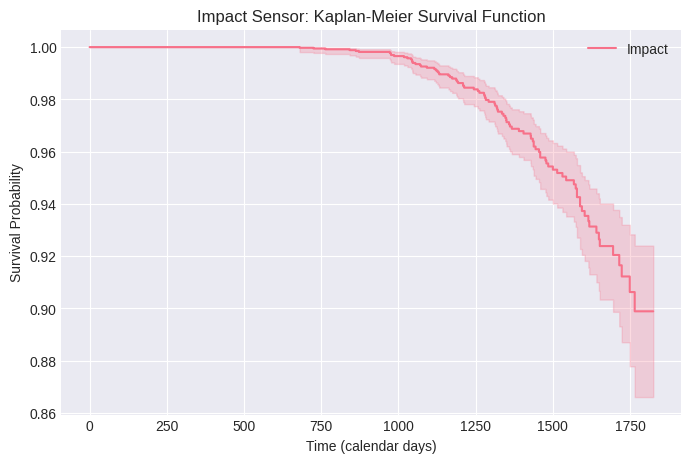


=== Impact: KM by Pets ===
With Pets: n=2629, failures=79 (3.0%)
Without Pets: n=3844, failures=12 (0.3%)


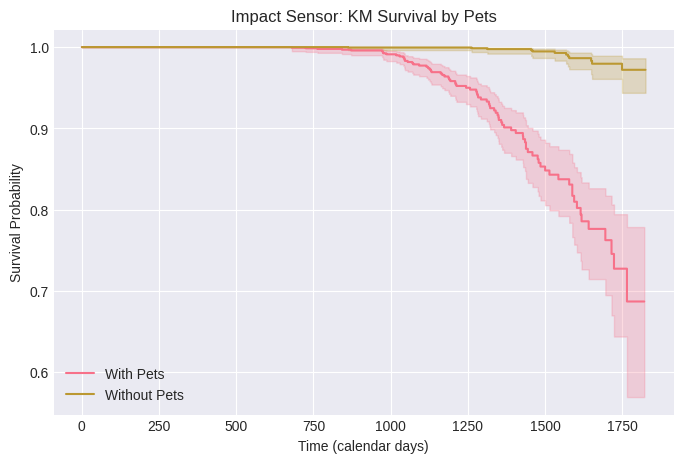


=== Impact: KM by Carpet Score ===
Low Carpet (1-3): n=4028, failures=83 (2.1%)
Medium Carpet (4-6): n=2348, failures=8 (0.3%)
High Carpet (7-9): n=97, failures=0 (0.0%)


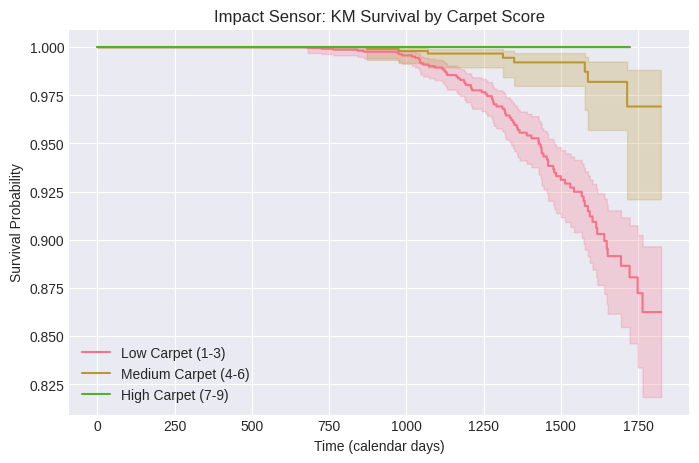


Log-rank test for Pets (Impact):
  Chi-square: 169.8159
  p-value: 0.0000

Log-rank test for Carpet Score (Impact):
  Chi-square: 12.4713
  p-value: 0.0004


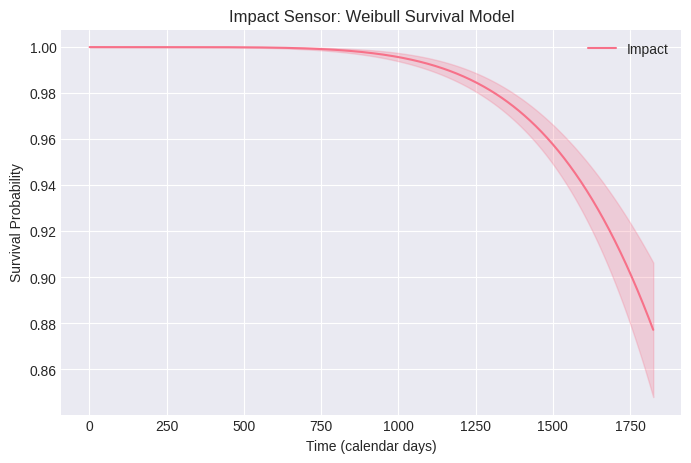


Weibull Parameters (Impact):
  Shape (ρ): 5.662
  Scale (λ): 2613.023
  AIC: 1907.41
  Log-likelihood: -951.70

Reliability Metrics:
  L10 (90% survive): 1756.0 days
  L50 (median): 2449.2 days
  MTTF (mean): 2416.3 days

=== Manufacturer Claim by Environment ===


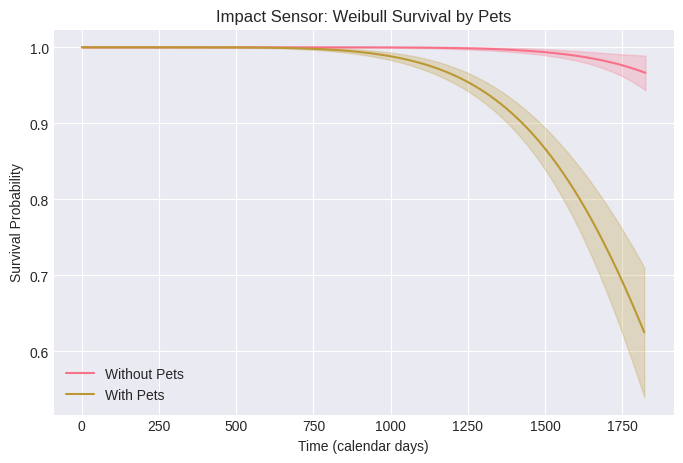

Without Pets: L10 = 2083 days
With Pets: L10 = 1427 days

=== Manufacturer Claim by Carpet Score ===
Carpet Low (1-3): L10 = 1649 days
Carpet Medium (4-6): L10 = 2249 days
Carpet High (7-9): L10 = 146690 days


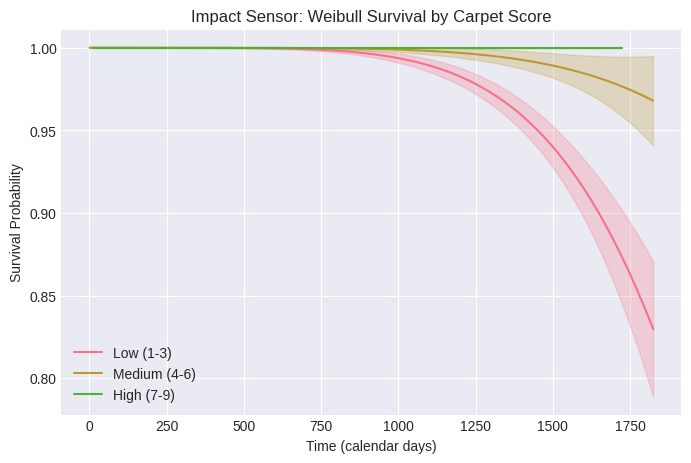


=== Cox PH Model (Impact) ===
                  coef  exp(coef)  se(coef)           p
covariate                                              
Pets           2.93099    18.7462  0.311592 5.12948e-21
Carpet_score -0.673298   0.510024  0.102503 5.08068e-11

Concordance: 0.877
Log-likelihood: -542.50
AIC (partial): 1089.01
L10: 1756 days [1684, 1831]
L50: 2449 days [2263, 2651]
MTTF: 2416 days


In [ ]:
# Basic Kaplan-Meier
kmf_impact = KaplanMeierFitter()
kmf_impact.fit(durations=df_ir['days_positive'],
               event_observed=df_ir['Impact_event'],
               label='Impact')

plt.figure(figsize=(8,5))
kmf_impact.plot_survival_function(ci_show=True)
plt.title('Impact Sensor: Kaplan-Meier Survival Function')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# Kaplan-Meier with covariates - Stratified by Pets
print("\n=== Impact: KM by Pets ===")
for pets_status, label in [(1, 'With Pets'), (0, 'Without Pets')]:
    mask = df_ir['Pets'] == pets_status
    n_total = mask.sum()
    n_fail = df_ir[mask]['Impact_event'].sum()
    print(f"{label}: n={n_total}, failures={n_fail} ({n_fail/n_total*100:.1f}%)")

plt.figure(figsize=(8,5))
kmf = KaplanMeierFitter()

for pets_status, label in [(1, 'With Pets'), (0, 'Without Pets')]:
    mask = df_ir['Pets'] == pets_status
    kmf.fit(durations=df_ir[mask]['days_positive'],
            event_observed=df_ir[mask]['Impact_event'],
            label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title('Impact Sensor: KM Survival by Pets')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

# Stratified by Carpet Score (3 groups)
print("\n=== Impact: KM by Carpet Score ===")
carpet_groups = [
    ((df_ir['Carpet_score'] >= 1) & (df_ir['Carpet_score'] <= 3), 'Low Carpet (1-3)'),
    ((df_ir['Carpet_score'] >= 4) & (df_ir['Carpet_score'] <= 6), 'Medium Carpet (4-6)'),
    ((df_ir['Carpet_score'] >= 7) & (df_ir['Carpet_score'] <= 9), 'High Carpet (7-9)')
]

for mask, label in carpet_groups:
    n_total = mask.sum()
    n_fail = df_ir[mask]['Impact_event'].sum()
    print(f"{label}: n={n_total}, failures={n_fail} ({n_fail/n_total*100:.1f}%)")

plt.figure(figsize=(8,5))

for mask, label in carpet_groups:
    kmf.fit(durations=df_ir[mask]['days_positive'],
            event_observed=df_ir[mask]['Impact_event'],
            label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title('Impact Sensor: KM Survival by Carpet Score')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

# Log-rank tests
group1_impact = df[df["Pets"] == 1]
group2_impact = df[df["Pets"] == 0]

resultpet_impact = logrank_test(
    durations_A = group1_impact["days_positive"],
    durations_B = group2_impact["days_positive"],
    event_observed_A = group1_impact["Impact_event"],
    event_observed_B = group2_impact["Impact_event"]
)

low_carpet_impact = df[df['Carpet_score'] < 5]
high_carpet_impact = df[df['Carpet_score'] >= 5]

resultcarpet_impact = logrank_test(
    high_carpet_impact['days_positive'], low_carpet_impact['days_positive'],
    event_observed_A=high_carpet_impact['Impact_event'],
    event_observed_B=low_carpet_impact['Impact_event']
)

print("\nLog-rank test for Pets (Impact):")
print(f"  Chi-square: {resultpet_impact.test_statistic:.4f}")
print(f"  p-value: {resultpet_impact.p_value:.4f}")
print("\nLog-rank test for Carpet Score (Impact):")
print(f"  Chi-square: {resultcarpet_impact.test_statistic:.4f}")
print(f"  p-value: {resultcarpet_impact.p_value:.4f}")

# Weibull parametric model
wf_impact = WeibullFitter()
wf_impact.fit(durations=df_ir['days_positive'],
              event_observed=df_ir['Impact_event'],
              label='Impact')

plt.figure(figsize=(8,5))
wf_impact.plot_survival_function()
plt.title('Impact Sensor: Weibull Survival Model')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# Extract parameters
shape_impact = wf_impact.rho_
scale_impact = wf_impact.lambda_
median_impact = wf_impact.median_survival_time_
l10_impact = wf_impact.percentile(0.90)
l50_impact = wf_impact.percentile(0.50)
mttf_impact = scale_impact * gamma(1 + 1/shape_impact)

print(f"\nWeibull Parameters (Impact):")
print(f"  Shape (ρ): {shape_impact:.3f}")
print(f"  Scale (λ): {scale_impact:.3f}")
print(f"  AIC: {wf_impact.AIC_:.2f}")
print(f"  Log-likelihood: {wf_impact.log_likelihood_:.2f}")

print(f"\nReliability Metrics:")
print(f"  L10 (90% survive): {l10_impact:.1f} days")
print(f"  L50 (median): {l50_impact:.1f} days")
print(f"  MTTF (mean): {mttf_impact:.1f} days")

# Stratified Weibull by Pets
print("\n=== Manufacturer Claim by Environment ===")

# Without pets
no_pets = df_ir[df_ir['Pets'] == 0]
wf_no_pets = WeibullFitter()
wf_no_pets.fit(no_pets['days_positive'], no_pets['Impact_event'])
l10_no_pets = wf_no_pets.percentile(0.90)

# With pets
pets = df_ir[df_ir['Pets'] == 1]
wf_pets = WeibullFitter()
wf_pets.fit(pets['days_positive'], pets['Impact_event'])
l10_pets = wf_pets.percentile(0.90)

plt.figure(figsize=(8,5))
wf_no_pets.plot_survival_function(label='Without Pets')
wf_pets.plot_survival_function(label='With Pets')
plt.title('Impact Sensor: Weibull Survival by Pets')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)
plt.show()

print(f"Without Pets: L10 = {l10_no_pets:.0f} days")
print(f"With Pets: L10 = {l10_pets:.0f} days")

# Stratified by Carpet Score
print("\n=== Manufacturer Claim by Carpet Score ===")

carpet_results = []
for carpet_range, label in [((1,3), 'Low (1-3)'), ((4,6), 'Medium (4-6)'), ((7,9), 'High (7-9)')]:
    mask = (df_ir['Carpet_score'] >= carpet_range[0]) & (df_ir['Carpet_score'] <= carpet_range[1])
    carpet_data = df_ir[mask]

    wf_carpet = WeibullFitter()
    wf_carpet.fit(carpet_data['days_positive'], carpet_data['Impact_event'], label=label)
    l10_carpet = wf_carpet.percentile(0.90)

    print(f"Carpet {label}: L10 = {l10_carpet:.0f} days")

# Plot all three
plt.figure(figsize=(8,5))
for carpet_range, label in [((1,3), 'Low (1-3)'), ((4,6), 'Medium (4-6)'), ((7,9), 'High (7-9)')]:
    mask = (df_ir['Carpet_score'] >= carpet_range[0]) & (df_ir['Carpet_score'] <= carpet_range[1])
    carpet_data = df_ir[mask]

    wf_carpet = WeibullFitter()
    wf_carpet.fit(carpet_data['days_positive'], carpet_data['Impact_event'], label=label)
    wf_carpet.plot_survival_function()

plt.title('Impact Sensor: Weibull Survival by Carpet Score')
plt.xlabel('Time (calendar days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)
plt.show()

# Cox Proportional Hazards model
cph_impact = CoxPHFitter()
cph_impact.fit(df_ir[['days_positive', 'Impact_event', 'Pets', 'Carpet_score']],
               duration_col='days_positive',
               event_col='Impact_event')

print("\n=== Cox PH Model (Impact) ===")
print(cph_impact.summary[['coef', 'exp(coef)', 'se(coef)', 'p']])
print(f"\nConcordance: {cph_impact.concordance_index_:.3f}")
print(f"Log-likelihood: {cph_impact.log_likelihood_:.2f}")
print(f"AIC (partial): {cph_impact.AIC_partial_:.2f}")

failures = df_ir[df_ir['Impact_event'] == 1]['days_positive'].values
censored = df_ir[df_ir['Impact_event'] == 0]['days_positive'].values

results = Fit_Weibull_2P(
    failures=failures,
    right_censored=censored,
    CI=0.95,
    quantiles=[0.10],
    CI_type='time',
    show_probability_plot=False,
    print_results=False
)

quantiles_df = results.quantiles
l10_row = quantiles_df[quantiles_df['Quantile'] == 0.1]

l10_point = l10_row['Point Estimate'].iloc[0]
l10_lower_ci = l10_row['Lower Estimate'].iloc[0]
l10_upper_ci = l10_row['Upper Estimate'].iloc[0]

results_l50 = Fit_Weibull_2P(
    failures=failures,
    right_censored=censored,
    CI=0.95,
    quantiles=[0.50],
    CI_type='time',
    show_probability_plot=False,
    print_results=False
)

l50_row = results_l50.quantiles[results_l50.quantiles['Quantile'] == 0.5]
l50_point = l50_row['Point Estimate'].iloc[0]
l50_lower_ci = l50_row['Lower Estimate'].iloc[0]
l50_upper_ci = l50_row['Upper Estimate'].iloc[0]

mttf_point = results.alpha * gamma(1 + 1/results.beta)

print(f"L10: {l10_point:.0f} days [{l10_lower_ci:.0f}, {l10_upper_ci:.0f}]")
print(f"L50: {l50_point:.0f} days [{l50_lower_ci:.0f}, {l50_upper_ci:.0f}]")
print(f"MTTF: {mttf_point:.0f} days")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')